In [ ]:
#Mount from drive
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
import numpy as np
import collections
import tensorflow as tf
from nltk.tokenize import word_tokenize
from tensorflow.keras import Model, layers
import csv
import re
import pylab
import time

In [ ]:
!pip install nltk
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
MAX_DOCUMENT_LENGTH = 100
N_FILTERS = 10
HIDDEN_SIZE = 20
EMBEDDING_SIZE = 50
FILTER_SHAPE1 = [20, 256]
POOLING_WINDOW = 4
POOLING_STRIDE = 2
MAX_LABEL = 15

batch_size = 128
no_epochs = 250
lr = 0.01

seed = 10
tf.random.set_seed(seed)

In [ ]:
def clean_str(text):
    text = re.sub(r"[^A-Za-z0-9(),!?\'\`\"]", " ", text)
    text = re.sub(r"\s{2,}", " ", text)
    text = text.strip().lower()

    return text

In [ ]:
def build_word_dict(contents):
    words = list()
    for content in contents:
        for word in word_tokenize(clean_str(content)):
            words.append(word)

    word_counter = collections.Counter(words).most_common()
    word_dict = dict()
    word_dict["<pad>"] = 0
    word_dict["<unk>"] = 1
    word_dict["<eos>"] = 2
    for word, _ in word_counter:
        word_dict[word] = len(word_dict)
    return word_dict

In [ ]:
def preprocess(contents, word_dict, document_max_len):
    x = list(map(lambda d: word_tokenize(clean_str(d)), contents))
    x = list(map(lambda d: list(map(lambda w: word_dict.get(w, word_dict["<unk>"]), d)), x))
    x = list(map(lambda d: d + [word_dict["<eos>"]], x))
    x = list(map(lambda d: d[:document_max_len], x))
    x = list(map(lambda d: d + (document_max_len - len(d)) * [word_dict["<pad>"]], x))
    return x

In [ ]:
def read_data_words():
    x_train, y_train, x_test, y_test = [], [], [], []
    cop = re.compile("[^a-z^A-Z^0-9^,^.^' ']")
    with open('./drive/My Drive/CZ4042/Assignment 2/train_medium.csv', encoding='utf-8') as filex:
        reader = csv.reader(filex)
        for row in reader:
            data = cop.sub("", row[1])
            x_train.append(data)
            y_train.append(int(row[0]))

    with open('./drive/My Drive/CZ4042/Assignment 2/test_medium.csv', encoding='utf-8') as filex:
        reader = csv.reader(filex)
        for row in reader:
            data = cop.sub("", row[1])
            x_test.append(data)
            y_test.append(int(row[0]))

    word_dict = build_word_dict(x_train+x_test)
    x_train = preprocess(x_train, word_dict, MAX_DOCUMENT_LENGTH)
    y_train = np.array(y_train)
    x_test = preprocess(x_test, word_dict, MAX_DOCUMENT_LENGTH)
    y_test = np.array(y_test)

    x_train = [x[:MAX_DOCUMENT_LENGTH] for x in x_train]
    x_test = [x[:MAX_DOCUMENT_LENGTH] for x in x_test]
    x_train = tf.constant(x_train, dtype=tf.int64)
    y_train = tf.constant(y_train, dtype=tf.int64)
    x_test = tf.constant(x_test, dtype=tf.int64)
    y_test = tf.constant(y_test, dtype=tf.int64)

    vocab_size = tf.get_static_value(tf.reduce_max(x_train))
    vocab_size = max(vocab_size, tf.get_static_value(tf.reduce_max(x_test))) + 1
    return x_train, y_train, x_test, y_test, vocab_size


In [ ]:
x_train, y_train, x_test, y_test, vocab_size = read_data_words()
# Use `tf.data` to batch and shuffle the dataset:
train_ds = tf.data.Dataset.from_tensor_slices(
    (x_train, y_train)).shuffle(10000).batch(batch_size)
test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(batch_size)


In [ ]:
# Build model
tf.keras.backend.set_floatx('float32')

# Q3

In [ ]:
# Training function
def train_step(model, x, label, drop_rate):
    with tf.GradientTape() as tape:
        out = model(x, drop_rate)
        loss = loss_object(label, out)
        gradients = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))
        
    train_loss(loss)
    train_accuracy(labels, out)

In [ ]:
# Testing function
def test_step(model, x, label, drop_rate=0):
    out = model(x,drop_rate)
    t_loss = loss_object(label, out)
    test_loss(t_loss)
    test_accuracy(label, out)

In [ ]:
class CharRNN(Model):

    def __init__(self, vocab_size, hidden_dim=10, add_dropout = False):
        super(CharRNN, self).__init__()
        # Hyperparameters
        self.hidden_dim = hidden_dim
        self.vocab_size = 256
        self.add_dropout = add_dropout
        self.embedding = layers.Embedding(vocab_size, EMBEDDING_SIZE, input_length=MAX_DOCUMENT_LENGTH)
        # Weight variables and RNN cell
        self.rnn = layers.RNN(
            tf.keras.layers.GRUCell(self.hidden_dim), unroll=True)
        self.dense = layers.Dense(MAX_LABEL, activation=None)

    def call(self, x, drop_rate):
        # forward logic
        x = tf.one_hot(x, self.vocab_size)
        encoding = self.rnn(x)
        if self.add_dropout:
          encoding = tf.nn.dropout(encoding, drop_rate)
        logits = self.dense(encoding)
    
        return logits

In [ ]:
#Select Model
model3 = CharRNN(vocab_size, HIDDEN_SIZE)

# Choose optimizer and loss function for training
optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

In [ ]:
# Select metrics to measure the loss and the accuracy of the model. 
# These metrics accumulate the values over epochs and then print the overall result.
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')

test_loss = tf.keras.metrics.Mean(name='test_loss')
test_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='test_accuracy')

In [ ]:
#Result array
test_acc_charRNN = []
train_loss_charRNN = []

#Start program time
start_time = time.time()

for epoch in range(no_epochs):
    # Reset the metrics at the start of the next epoch
    train_loss.reset_states()
    train_accuracy.reset_states()
    test_loss.reset_states()
    test_accuracy.reset_states()

    for images, labels in train_ds:
        train_step(model3, images, labels, drop_rate=0.5)

    for images, labels in test_ds:
        test_step(model3, images, labels, drop_rate=0)

    test_acc_charRNN.append(test_accuracy.result())
    train_loss_charRNN.append(train_loss.result())
    template = 'Epoch {}, Loss: {}, Accuracy: {}, Test Loss: {}, Test Accuracy: {}'
    print (template.format(epoch+1,
                          train_loss.result(),
                          train_accuracy.result(),
                          test_loss.result(),
                          test_accuracy.result()))
    
#Store program execution time
time_charRNN = time.time() - start_time
print("--- Took: %s seconds ---" % (time_charRNN))

Epoch 1, Loss: 2.66123628616333, Accuracy: 0.06892856955528259, Test Loss: 2.646352529525757, Test Accuracy: 0.0714285746216774
Epoch 2, Loss: 2.647761821746826, Accuracy: 0.07107143104076385, Test Loss: 2.6454074382781982, Test Accuracy: 0.07285714149475098
Epoch 3, Loss: 2.419309616088867, Accuracy: 0.1416071355342865, Test Loss: 2.0324840545654297, Test Accuracy: 0.2928571403026581
Epoch 4, Loss: 1.7942043542861938, Accuracy: 0.33892858028411865, Test Loss: 1.5509405136108398, Test Accuracy: 0.44999998807907104
Epoch 5, Loss: 1.3467910289764404, Accuracy: 0.5296428799629211, Test Loss: 1.278357982635498, Test Accuracy: 0.558571457862854
Epoch 6, Loss: 1.1076194047927856, Accuracy: 0.6617857217788696, Test Loss: 1.0025955438613892, Test Accuracy: 0.7085714340209961
Epoch 7, Loss: 0.7961858510971069, Accuracy: 0.774821400642395, Test Loss: 0.8254762291908264, Test Accuracy: 0.7671428322792053
Epoch 8, Loss: 0.6191319227218628, Accuracy: 0.818928599357605, Test Loss: 0.7876022458076477

In [ ]:
#Running time of execution
print(str(time_charRNN/60)[0:4]+" mins")

44.3 mins


No handles with labels found to put in legend.


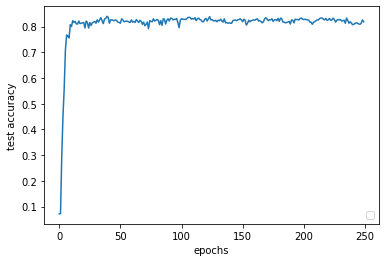

In [ ]:
# Plot test accuracy
pylab.figure()
pylab.plot(np.arange(no_epochs), test_acc_charRNN)
pylab.xlabel('epochs')
pylab.ylabel('test accuracy')
pylab.legend(loc='lower right')

No handles with labels found to put in legend.


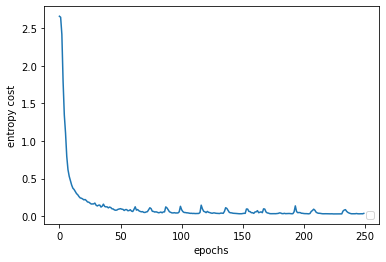

In [ ]:
# Plot entropy cost
pylab.figure()
pylab.plot(np.arange(no_epochs), train_loss_charRNN)
pylab.xlabel('epochs')
pylab.ylabel('entropy cost')
pylab.legend(loc='lower right')

# Q4

In [ ]:
class WordRNN(Model):

    def __init__(self, vocab_size, hidden_dim=10, add_dropout = False):
        super(WordRNN, self).__init__()
        # Hyperparameters
        self.hidden_dim = hidden_dim
        self.vocab_size = vocab_size
        self.add_dropout = add_dropout
        self.embedding = layers.Embedding(vocab_size, EMBEDDING_SIZE, input_length=MAX_DOCUMENT_LENGTH)
        # Weight variables and RNN cell
        self.rnn = layers.RNN(
            tf.keras.layers.GRUCell(self.hidden_dim), unroll=True)
        self.dense = layers.Dense(MAX_LABEL, activation=None)

    def call(self, x, drop_rate):
        # forward logic
        embedding = self.embedding(x)
        encoding = self.rnn(embedding)
        if self.add_dropout:
          encoding = tf.nn.dropout(encoding, drop_rate)
        logits = self.dense(encoding)
    
        return logits

In [ ]:
model4 = WordRNN(vocab_size, HIDDEN_SIZE)

# Choose optimizer and loss function for training
optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

In [ ]:
# Select metrics to measure the loss and the accuracy of the model. 
# These metrics accumulate the values over epochs and then print the overall result.
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')

test_loss = tf.keras.metrics.Mean(name='test_loss')
test_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='test_accuracy')

In [ ]:
#Result array
test_acc_wordRNN = []
train_loss_wordRNN = []

#Start program time
start_time = time.time()

for epoch in range(no_epochs):
    # Reset the metrics at the start of the next epoch
    train_loss.reset_states()
    train_accuracy.reset_states()
    test_loss.reset_states()
    test_accuracy.reset_states()

    for images, labels in train_ds:
        train_step(model4, images, labels, drop_rate=0.5)

    for images, labels in test_ds:
        test_step(model4, images, labels, drop_rate=0)

    test_acc_wordRNN.append(test_accuracy.result())
    train_loss_wordRNN.append(train_loss.result())
    template = 'Epoch {}, Loss: {}, Accuracy: {}, Test Loss: {}, Test Accuracy: {}'
    print (template.format(epoch+1,
                          train_loss.result(),
                          train_accuracy.result(),
                          test_loss.result(),
                          test_accuracy.result()))
    
#Store program execution time
time_wordRNN = time.time() - start_time
print("--- Took: %s seconds ---" % (time_wordRNN))

Epoch 1, Loss: 2.6648917198181152, Accuracy: 0.06607142835855484, Test Loss: 2.648974657058716, Test Accuracy: 0.0714285746216774
Epoch 2, Loss: 2.5934348106384277, Accuracy: 0.09964285790920258, Test Loss: 2.3016717433929443, Test Accuracy: 0.22714285552501678
Epoch 3, Loss: 1.8945647478103638, Accuracy: 0.2646428644657135, Test Loss: 1.6366667747497559, Test Accuracy: 0.3928571343421936
Epoch 4, Loss: 1.216748833656311, Accuracy: 0.5249999761581421, Test Loss: 1.1512341499328613, Test Accuracy: 0.6285714507102966
Epoch 5, Loss: 0.6877645254135132, Accuracy: 0.7628571391105652, Test Loss: 0.8321536183357239, Test Accuracy: 0.7357142567634583
Epoch 6, Loss: 0.33651238679885864, Accuracy: 0.9051785469055176, Test Loss: 0.6813809275627136, Test Accuracy: 0.7971428632736206
Epoch 7, Loss: 0.167127326130867, Accuracy: 0.9594643115997314, Test Loss: 0.6066628098487854, Test Accuracy: 0.8357142806053162
Epoch 8, Loss: 0.10698986798524857, Accuracy: 0.9746428728103638, Test Loss: 0.6053407192

In [ ]:
#Running time of execution
print(str(time_wordRNN/60)[0:4]+" mins")

44.3 mins


No handles with labels found to put in legend.


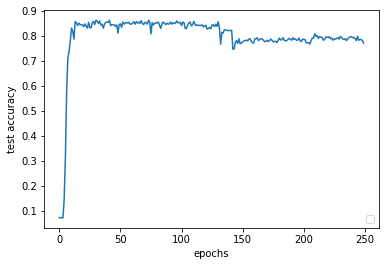

In [ ]:

# Plot test accuracy
pylab.figure()
pylab.plot(np.arange(no_epochs), test_acc_wordRNN)
pylab.xlabel('epochs')
pylab.ylabel('test accuracy')
pylab.legend(loc='lower right')

No handles with labels found to put in legend.


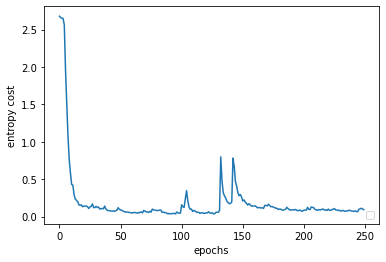

In [ ]:
# Plot entropy cost
pylab.figure()
pylab.plot(np.arange(no_epochs), train_loss_wordRNN)
pylab.xlabel('epochs')
pylab.ylabel('entropy cost')
pylab.legend(loc='lower right')

# Q5

With Dropouts

In [ ]:
model_char_rnn_dropout = CharRNN(vocab_size, HIDDEN_SIZE, add_dropout = True)

# Choose optimizer and loss function for training
optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
# Select metrics to measure the loss and the accuracy of the model. 
# These metrics accumulate the values over epochs and then print the overall result.
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')

test_loss = tf.keras.metrics.Mean(name='test_loss')
test_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='test_accuracy')

#Result array
test_acc_charRNN_dropout = []
train_loss_charRNN_dropout = []

#Start program time
start_time = time.time()

for epoch in range(no_epochs):
    # Reset the metrics at the start of the next epoch
    train_loss.reset_states()
    train_accuracy.reset_states()
    test_loss.reset_states()
    test_accuracy.reset_states()

    for images, labels in train_ds:
        train_step(model_char_rnn_dropout, images, labels, drop_rate=0.5)

    for images, labels in test_ds:
        test_step(model_char_rnn_dropout, images, labels, drop_rate=0)

    test_acc_charRNN_dropout.append(test_accuracy.result())
    train_loss_charRNN_dropout.append(train_loss.result())
    template = 'Epoch {}, Loss: {}, Accuracy: {}, Test Loss: {}, Test Accuracy: {}'
    print (template.format(epoch+1,
                          train_loss.result(),
                          train_accuracy.result(),
                          test_loss.result(),
                          test_accuracy.result()))
    
#Store program execution time
time_charRNN_dropout = time.time() - start_time
print("--- Took: %s seconds ---" % (time_charRNN_dropout))

Epoch 1, Loss: 2.6800284385681152, Accuracy: 0.07214285433292389, Test Loss: 2.6518352031707764, Test Accuracy: 0.0714285746216774
Epoch 2, Loss: 2.6612625122070312, Accuracy: 0.07053571194410324, Test Loss: 2.649195909500122, Test Accuracy: 0.0714285746216774
Epoch 3, Loss: 2.6528120040893555, Accuracy: 0.07035714387893677, Test Loss: 2.6459624767303467, Test Accuracy: 0.0714285746216774
Epoch 4, Loss: 2.649416446685791, Accuracy: 0.0701785683631897, Test Loss: 2.6421096324920654, Test Accuracy: 0.0714285746216774
Epoch 5, Loss: 2.648667812347412, Accuracy: 0.07000000029802322, Test Loss: 2.641948699951172, Test Accuracy: 0.07285714149475098
Epoch 6, Loss: 2.6402642726898193, Accuracy: 0.07696428894996643, Test Loss: 2.558333158493042, Test Accuracy: 0.22142857313156128
Epoch 7, Loss: 1.9401127099990845, Accuracy: 0.33125001192092896, Test Loss: 1.1706970930099487, Test Accuracy: 0.6085714101791382
Epoch 8, Loss: 1.109104037284851, Accuracy: 0.5996428728103638, Test Loss: 0.8553753495

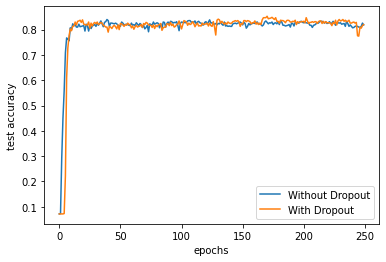

In [ ]:
# Plot test accuracy w and w/o dropout
pylab.figure()
pylab.plot(np.arange(no_epochs), test_acc_charRNN, label='Without Dropout')
pylab.plot(np.arange(no_epochs), test_acc_charRNN_dropout, label='With Dropout')
pylab.xlabel('epochs')
pylab.ylabel('test accuracy')
pylab.legend(loc='lower right')

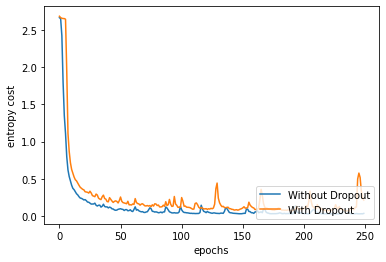

In [ ]:
# Plot entropy cost
pylab.figure()
pylab.plot(np.arange(no_epochs), train_loss_charRNN, label='Without Dropout')
pylab.plot(np.arange(no_epochs), train_loss_charRNN_dropout, label='With Dropout')
pylab.xlabel('epochs')
pylab.ylabel('entropy cost')
pylab.legend(loc='lower right')

In [ ]:
model_word_rnn_dropout = WordRNN(vocab_size, HIDDEN_SIZE, add_dropout = True)

# Choose optimizer and loss function for training
optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
# Select metrics to measure the loss and the accuracy of the model. 
# These metrics accumulate the values over epochs and then print the overall result.
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')

test_loss = tf.keras.metrics.Mean(name='test_loss')
test_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='test_accuracy')

#Result array
test_acc_wordRNN_dropout = []
train_loss_wordRNN_dropout = []

#Start program time
start_time = time.time()

for epoch in range(no_epochs):
    # Reset the metrics at the start of the next epoch
    train_loss.reset_states()
    train_accuracy.reset_states()
    test_loss.reset_states()
    test_accuracy.reset_states()

    for images, labels in train_ds:
        train_step(model_word_rnn_dropout, images, labels, drop_rate=0.5)

    for images, labels in test_ds:
        test_step(model_word_rnn_dropout, images, labels, drop_rate=0)

    test_acc_wordRNN_dropout.append(test_accuracy.result())
    train_loss_wordRNN_dropout.append(train_loss.result())
    template = 'Epoch {}, Loss: {}, Accuracy: {}, Test Loss: {}, Test Accuracy: {}'
    print (template.format(epoch+1,
                          train_loss.result(),
                          train_accuracy.result(),
                          test_loss.result(),
                          test_accuracy.result()))
    
#Store program execution time
time_wordRNN_dropout = time.time() - start_time
print("--- Took: %s seconds ---" % (time_wordRNN_dropout))

Epoch 1, Loss: 2.6840426921844482, Accuracy: 0.06321428716182709, Test Loss: 2.6567766666412354, Test Accuracy: 0.0714285746216774
Epoch 2, Loss: 2.6610188484191895, Accuracy: 0.07107143104076385, Test Loss: 2.649951457977295, Test Accuracy: 0.0714285746216774
Epoch 3, Loss: 2.652461528778076, Accuracy: 0.07517857104539871, Test Loss: 2.6465389728546143, Test Accuracy: 0.07000000029802322
Epoch 4, Loss: 2.649724245071411, Accuracy: 0.07571428269147873, Test Loss: 2.6460120677948, Test Accuracy: 0.0714285746216774
Epoch 5, Loss: 2.5377461910247803, Accuracy: 0.11910714209079742, Test Loss: 2.073511838912964, Test Accuracy: 0.23999999463558197
Epoch 6, Loss: 1.4593220949172974, Accuracy: 0.5101785659790039, Test Loss: 0.8842258453369141, Test Accuracy: 0.7085714340209961
Epoch 7, Loss: 0.7860190868377686, Accuracy: 0.7321428656578064, Test Loss: 0.6789002418518066, Test Accuracy: 0.7799999713897705
Epoch 8, Loss: 0.5091471076011658, Accuracy: 0.814464271068573, Test Loss: 0.6489700675010

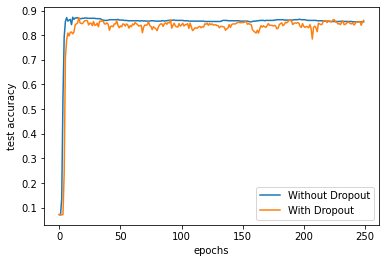

In [ ]:

# Plot test accuracy w and w/o dropout
pylab.figure()
pylab.plot(np.arange(no_epochs), test_acc_wordRNN, label='Without Dropout')
pylab.plot(np.arange(no_epochs), test_acc_wordRNN_dropout, label='With Dropout')
pylab.xlabel('epochs')
pylab.ylabel('test accuracy')
pylab.legend(loc='lower right')

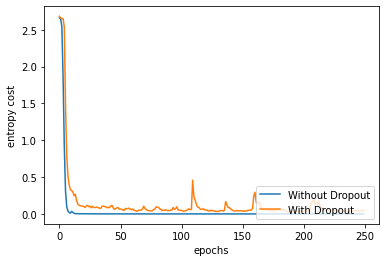

In [ ]:
# Plot entropy cost
pylab.figure()
pylab.plot(np.arange(no_epochs), train_loss_wordRNN, label='Without Dropout')
pylab.plot(np.arange(no_epochs), train_loss_wordRNN_dropout, label='With Dropout')
pylab.xlabel('epochs')
pylab.ylabel('entropy cost')
pylab.legend(loc='lower right')

# Q6

## A: Replace the GRU layer with (i) a vanilla RNN layer and (ii) a LSTM layer

In [ ]:
class CharRNN_vanilla(Model):

    def __init__(self, vocab_size, hidden_dim=10, add_dropout = False):
        super(CharRNN_vanilla, self).__init__()
        # Hyperparameters
        self.hidden_dim = hidden_dim
        self.vocab_size = 256
        self.add_dropout = add_dropout
        self.embedding = layers.Embedding(vocab_size, EMBEDDING_SIZE, input_length=MAX_DOCUMENT_LENGTH)
        # Weight variables and RNN cell
        self.rnn = layers.RNN(
            tf.keras.layers.SimpleRNNCell(self.hidden_dim), unroll=True)
        self.dense = layers.Dense(MAX_LABEL, activation=None)

    def call(self, x, drop_rate):
        # forward logic
        x = tf.one_hot(x, self.vocab_size)
        encoding = self.rnn(x)
        if self.add_dropout:
          encoding = tf.nn.dropout(encoding, drop_rate)
        logits = self.dense(encoding)
    
        return logits

In [ ]:
model_char_vanilla_rnn = CharRNN_vanilla(vocab_size, HIDDEN_SIZE, add_dropout = True)

# Choose optimizer and loss function for training
optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
# Select metrics to measure the loss and the accuracy of the model. 
# These metrics accumulate the values over epochs and then print the overall result.
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')

test_loss = tf.keras.metrics.Mean(name='test_loss')
test_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='test_accuracy')

#Result array
test_acc_charRNN_vanilla = []
train_loss_charRNN_vanilla = []

#Start program time
start_time = time.time()

for epoch in range(no_epochs):
    # Reset the metrics at the start of the next epoch
    train_loss.reset_states()
    train_accuracy.reset_states()
    test_loss.reset_states()
    test_accuracy.reset_states()

    for images, labels in train_ds:
        train_step(model_char_vanilla_rnn, images, labels, drop_rate=0.5)

    for images, labels in test_ds:
        test_step(model_char_vanilla_rnn, images, labels, drop_rate=0)

    test_acc_charRNN_vanilla.append(test_accuracy.result())
    train_loss_charRNN_vanilla.append(train_loss.result())
    template = 'Epoch {}, Loss: {}, Accuracy: {}, Test Loss: {}, Test Accuracy: {}'
    print (template.format(epoch+1,
                          train_loss.result(),
                          train_accuracy.result(),
                          test_loss.result(),
                          test_accuracy.result()))
    
#Store program execution time
time_charRNN_vanilla = time.time() - start_time
print("--- Took: %s seconds ---" % (time_charRNN_vanilla))

Epoch 1, Loss: 2.696486234664917, Accuracy: 0.07035714387893677, Test Loss: 2.6572365760803223, Test Accuracy: 0.07857143133878708
Epoch 2, Loss: 2.661896228790283, Accuracy: 0.07178571075201035, Test Loss: 2.650906562805176, Test Accuracy: 0.07857143133878708
Epoch 3, Loss: 2.655022621154785, Accuracy: 0.07196428626775742, Test Loss: 2.64460825920105, Test Accuracy: 0.0714285746216774
Epoch 4, Loss: 2.651630401611328, Accuracy: 0.06321428716182709, Test Loss: 2.6418516635894775, Test Accuracy: 0.07000000029802322
Epoch 5, Loss: 2.6481773853302, Accuracy: 0.0694642886519432, Test Loss: 2.643261432647705, Test Accuracy: 0.07285714149475098
Epoch 6, Loss: 2.6452527046203613, Accuracy: 0.07678571343421936, Test Loss: 2.6427721977233887, Test Accuracy: 0.0657142847776413
Epoch 7, Loss: 2.647329568862915, Accuracy: 0.06839285790920258, Test Loss: 2.6423323154449463, Test Accuracy: 0.07999999821186066
Epoch 8, Loss: 2.6421492099761963, Accuracy: 0.07553571462631226, Test Loss: 2.641403198242

In [ ]:
class CharRNN_lstm(Model):

    def __init__(self, vocab_size, hidden_dim=10, add_dropout = False):
        super(CharRNN_lstm, self).__init__()
        # Hyperparameters
        self.hidden_dim = hidden_dim
        self.vocab_size = 256
        self.add_dropout = add_dropout
        self.embedding = layers.Embedding(vocab_size, EMBEDDING_SIZE, input_length=MAX_DOCUMENT_LENGTH)
        # Weight variables and RNN cell
        self.rnn = layers.RNN(
            tf.keras.layers.LSTMCell(self.hidden_dim), unroll=True)
        self.dense = layers.Dense(MAX_LABEL, activation=None)

    def call(self, x, drop_rate):
        # forward logic
        x = tf.one_hot(x, self.vocab_size)
        encoding = self.rnn(x)
        if self.add_dropout:
          encoding = tf.nn.dropout(encoding, drop_rate)
        logits = self.dense(encoding)
    
        return logits

In [ ]:
model_char_lstm_rnn = CharRNN_lstm(vocab_size, HIDDEN_SIZE, add_dropout = True)

# Choose optimizer and loss function for training
optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
# Select metrics to measure the loss and the accuracy of the model. 
# These metrics accumulate the values over epochs and then print the overall result.
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')

test_loss = tf.keras.metrics.Mean(name='test_loss')
test_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='test_accuracy')

#Result array
test_acc_charRNN_lstm = []
train_loss_charRNN_lstm = []

#Start program time
start_time = time.time()

for epoch in range(no_epochs):
    # Reset the metrics at the start of the next epoch
    train_loss.reset_states()
    train_accuracy.reset_states()
    test_loss.reset_states()
    test_accuracy.reset_states()

    for images, labels in train_ds:
        train_step(model_char_lstm_rnn, images, labels, drop_rate=0.5)

    for images, labels in test_ds:
        test_step(model_char_lstm_rnn, images, labels, drop_rate=0)

    test_acc_charRNN_lstm.append(test_accuracy.result())
    train_loss_charRNN_lstm.append(train_loss.result())
    template = 'Epoch {}, Loss: {}, Accuracy: {}, Test Loss: {}, Test Accuracy: {}'
    print (template.format(epoch+1,
                          train_loss.result(),
                          train_accuracy.result(),
                          test_loss.result(),
                          test_accuracy.result()))
    
#Store program execution time
time_charRNN_lstm = time.time() - start_time
print("--- Took: %s seconds ---" % (time_charRNN_lstm))

Epoch 1, Loss: 2.681161642074585, Accuracy: 0.06410714238882065, Test Loss: 2.6545753479003906, Test Accuracy: 0.07285714149475098
Epoch 2, Loss: 2.6604578495025635, Accuracy: 0.07089285552501678, Test Loss: 2.6475038528442383, Test Accuracy: 0.07285714149475098
Epoch 3, Loss: 2.6502771377563477, Accuracy: 0.07214285433292389, Test Loss: 2.643893003463745, Test Accuracy: 0.07000000029802322
Epoch 4, Loss: 2.6509945392608643, Accuracy: 0.06553571671247482, Test Loss: 2.643282175064087, Test Accuracy: 0.07285714149475098
Epoch 5, Loss: 2.646217107772827, Accuracy: 0.06624999642372131, Test Loss: 2.641756772994995, Test Accuracy: 0.0714285746216774
Epoch 6, Loss: 2.6465816497802734, Accuracy: 0.07000000029802322, Test Loss: 2.641195297241211, Test Accuracy: 0.0714285746216774
Epoch 7, Loss: 2.645195245742798, Accuracy: 0.06660714000463486, Test Loss: 2.6423048973083496, Test Accuracy: 0.0714285746216774
Epoch 8, Loss: 2.6452713012695312, Accuracy: 0.06678571552038193, Test Loss: 2.6408436

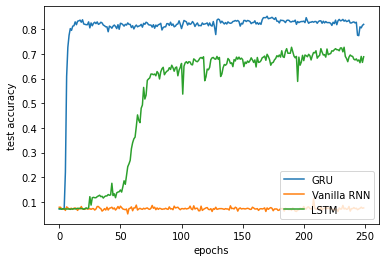

In [ ]:
# Plot test accuracy of all three
pylab.figure()
pylab.plot(np.arange(no_epochs), test_acc_charRNN_dropout, label='GRU')
pylab.plot(np.arange(no_epochs), test_acc_charRNN_vanilla, label='Vanilla RNN')
pylab.plot(np.arange(no_epochs), test_acc_charRNN_lstm, label='LSTM')
pylab.xlabel('epochs')
pylab.ylabel('test accuracy')
pylab.legend(loc='lower right')

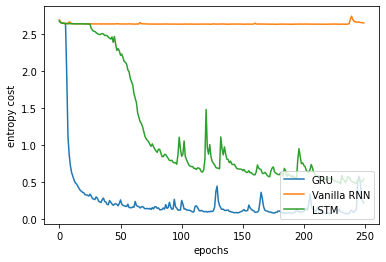

In [ ]:
# Plot entropy cost of all three
pylab.figure()
pylab.plot(np.arange(no_epochs), train_loss_charRNN_dropout, label='GRU')
pylab.plot(np.arange(no_epochs), train_loss_charRNN_vanilla, label='Vanilla RNN')
pylab.plot(np.arange(no_epochs), train_loss_charRNN_lstm, label='LSTM')
pylab.xlabel('epochs')
pylab.ylabel('entropy cost')
pylab.legend(loc='lower right')

In [ ]:
class WordRNN_vanilla(Model):

    def __init__(self, vocab_size, hidden_dim=10, add_dropout = False):
        super(WordRNN_vanilla, self).__init__()
        # Hyperparameters
        self.hidden_dim = hidden_dim
        self.vocab_size = vocab_size
        self.add_dropout = add_dropout
        self.embedding = layers.Embedding(vocab_size, EMBEDDING_SIZE, input_length=MAX_DOCUMENT_LENGTH)
        # Weight variables and RNN cell
        self.rnn = layers.RNN(
            tf.keras.layers.SimpleRNNCell(self.hidden_dim), unroll=True)
        self.dense = layers.Dense(MAX_LABEL, activation=None)

    def call(self, x, drop_rate):
        # forward logic
        embedding = self.embedding(x)
        encoding = self.rnn(embedding)
        if self.add_dropout:
          encoding = tf.nn.dropout(encoding, drop_rate)
        logits = self.dense(encoding)
    
        return logits

In [ ]:
model_word_vanilla_rnn = WordRNN_vanilla(vocab_size, HIDDEN_SIZE, add_dropout = True)

# Choose optimizer and loss function for training
optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
# Select metrics to measure the loss and the accuracy of the model. 
# These metrics accumulate the values over epochs and then print the overall result.
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')

test_loss = tf.keras.metrics.Mean(name='test_loss')
test_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='test_accuracy')

#Result array
test_acc_wordRNN_vanilla = []
train_loss_wordRNN_vanilla = []

#Start program time
start_time = time.time()

for epoch in range(no_epochs):
    # Reset the metrics at the start of the next epoch
    train_loss.reset_states()
    train_accuracy.reset_states()
    test_loss.reset_states()
    test_accuracy.reset_states()

    for images, labels in train_ds:
        train_step(model_word_vanilla_rnn, images, labels, drop_rate=0.5)

    for images, labels in test_ds:
        test_step(model_word_vanilla_rnn, images, labels, drop_rate=0)

    test_acc_wordRNN_vanilla.append(test_accuracy.result())
    train_loss_wordRNN_vanilla.append(train_loss.result())
    template = 'Epoch {}, Loss: {}, Accuracy: {}, Test Loss: {}, Test Accuracy: {}'
    print (template.format(epoch+1,
                          train_loss.result(),
                          train_accuracy.result(),
                          test_loss.result(),
                          test_accuracy.result()))
    
#Store program execution time
time_wordRNN_vanilla = time.time() - start_time
print("--- Took: %s seconds ---" % (time_wordRNN_vanilla))

Epoch 1, Loss: 2.7069003582000732, Accuracy: 0.07392857223749161, Test Loss: 2.6615188121795654, Test Accuracy: 0.07999999821186066
Epoch 2, Loss: 2.6378085613250732, Accuracy: 0.09196428209543228, Test Loss: 2.6482598781585693, Test Accuracy: 0.07571428269147873
Epoch 3, Loss: 2.65816330909729, Accuracy: 0.07660714536905289, Test Loss: 2.65463924407959, Test Accuracy: 0.0714285746216774
Epoch 4, Loss: 2.6406548023223877, Accuracy: 0.08821428567171097, Test Loss: 2.6580944061279297, Test Accuracy: 0.07999999821186066
Epoch 5, Loss: 2.6534528732299805, Accuracy: 0.0701785683631897, Test Loss: 2.6437957286834717, Test Accuracy: 0.07285714149475098
Epoch 6, Loss: 2.6400322914123535, Accuracy: 0.07785714417695999, Test Loss: 2.6807003021240234, Test Accuracy: 0.08285713940858841
Epoch 7, Loss: 2.616859197616577, Accuracy: 0.1014285683631897, Test Loss: 2.643883466720581, Test Accuracy: 0.0771428570151329
Epoch 8, Loss: 2.600177526473999, Accuracy: 0.11375000327825546, Test Loss: 2.62544178

In [ ]:
class WordRNN_lstm(Model):

    def __init__(self, vocab_size, hidden_dim=10, add_dropout = False):
        super(WordRNN_lstm, self).__init__()
        # Hyperparameters
        self.hidden_dim = hidden_dim
        self.vocab_size = vocab_size
        self.add_dropout = add_dropout
        self.embedding = layers.Embedding(vocab_size, EMBEDDING_SIZE, input_length=MAX_DOCUMENT_LENGTH)
        # Weight variables and RNN cell
        self.rnn = layers.RNN(
            tf.keras.layers.LSTMCell(self.hidden_dim), unroll=True)
        self.dense = layers.Dense(MAX_LABEL, activation=None)

    def call(self, x, drop_rate):
        # forward logic
        embedding = self.embedding(x)
        encoding = self.rnn(embedding)
        if self.add_dropout:
          encoding = tf.nn.dropout(encoding, drop_rate)
        logits = self.dense(encoding)
    
        return logits

In [ ]:
model_word_lstm_rnn = WordRNN_lstm(vocab_size, HIDDEN_SIZE, add_dropout = True)

# Choose optimizer and loss function for training
optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
# Select metrics to measure the loss and the accuracy of the model. 
# These metrics accumulate the values over epochs and then print the overall result.
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')

test_loss = tf.keras.metrics.Mean(name='test_loss')
test_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='test_accuracy')

#Result array
test_acc_wordRNN_lstm = []
train_loss_wordRNN_lstm = []

#Start program time
start_time = time.time()

for epoch in range(no_epochs):
    # Reset the metrics at the start of the next epoch
    train_loss.reset_states()
    train_accuracy.reset_states()
    test_loss.reset_states()
    test_accuracy.reset_states()

    for images, labels in train_ds:
        train_step(model_word_lstm_rnn, images, labels, drop_rate=0.5)

    for images, labels in test_ds:
        test_step(model_word_lstm_rnn, images, labels, drop_rate=0)

    test_acc_wordRNN_lstm.append(test_accuracy.result())
    train_loss_wordRNN_lstm.append(train_loss.result())
    template = 'Epoch {}, Loss: {}, Accuracy: {}, Test Loss: {}, Test Accuracy: {}'
    print (template.format(epoch+1,
                          train_loss.result(),
                          train_accuracy.result(),
                          test_loss.result(),
                          test_accuracy.result()))
    
#Store program execution time
time_wordRNN_lstm = time.time() - start_time
print("--- Took: %s seconds ---" % (time_wordRNN_lstm))

Epoch 1, Loss: 2.6814777851104736, Accuracy: 0.07214285433292389, Test Loss: 2.6599507331848145, Test Accuracy: 0.0714285746216774
Epoch 2, Loss: 2.6579971313476562, Accuracy: 0.06678571552038193, Test Loss: 2.647270441055298, Test Accuracy: 0.0714285746216774
Epoch 3, Loss: 2.6541731357574463, Accuracy: 0.07035714387893677, Test Loss: 2.644402265548706, Test Accuracy: 0.0714285746216774
Epoch 4, Loss: 2.6499438285827637, Accuracy: 0.06553571671247482, Test Loss: 2.643066167831421, Test Accuracy: 0.0714285746216774
Epoch 5, Loss: 2.646702289581299, Accuracy: 0.06982143223285675, Test Loss: 2.642181634902954, Test Accuracy: 0.0714285746216774
Epoch 6, Loss: 2.6468145847320557, Accuracy: 0.07374999672174454, Test Loss: 2.6421871185302734, Test Accuracy: 0.0714285746216774
Epoch 7, Loss: 2.644347906112671, Accuracy: 0.07071428745985031, Test Loss: 2.6412246227264404, Test Accuracy: 0.0714285746216774
Epoch 8, Loss: 2.643597364425659, Accuracy: 0.07089285552501678, Test Loss: 2.64276146888

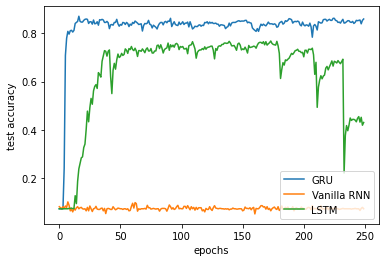

In [ ]:

# Plot test accuracy of all three
pylab.figure()
pylab.plot(np.arange(no_epochs), test_acc_wordRNN_dropout, label='GRU')
pylab.plot(np.arange(no_epochs), test_acc_wordRNN_vanilla, label='Vanilla RNN')
pylab.plot(np.arange(no_epochs), test_acc_wordRNN_lstm, label='LSTM')
pylab.xlabel('epochs')
pylab.ylabel('test accuracy')
pylab.legend(loc='lower right')

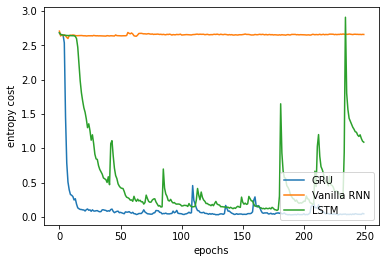

In [ ]:

# Plot entropy cost of all three
pylab.figure()
pylab.plot(np.arange(no_epochs), train_loss_wordRNN_dropout, label='GRU')
pylab.plot(np.arange(no_epochs), train_loss_wordRNN_vanilla, label='Vanilla RNN')
pylab.plot(np.arange(no_epochs), train_loss_wordRNN_lstm, label='LSTM')
pylab.xlabel('epochs')
pylab.ylabel('entropy cost')
pylab.legend(loc='lower right')

# B) Increase the number of RNN layers to 2 layers

In [ ]:
class CharRNN_increase(Model):

    def __init__(self, vocab_size, hidden_dim=10, add_dropout = False):
        super(CharRNN_increase, self).__init__()
        # Hyperparameters
        self.hidden_dim = hidden_dim
        self.vocab_size = 256
        self.add_dropout = add_dropout
        self.embedding = layers.Embedding(vocab_size, EMBEDDING_SIZE, input_length=MAX_DOCUMENT_LENGTH)
        # Weight variables and RNN cell
        self.rnn = layers.RNN(
            tf.keras.layers.StackedRNNCells([tf.keras.layers.GRUCell(self.hidden_dim), 
                                             tf.keras.layers.GRUCell(self.hidden_dim)]), unroll=True)
        self.dense = layers.Dense(MAX_LABEL, activation=None)

    def call(self, x, drop_rate):
        # forward logic
        x = tf.one_hot(x, self.vocab_size)
        encoding = self.rnn(x)
        if self.add_dropout:
          encoding = tf.nn.dropout(encoding, drop_rate)
        logits = self.dense(encoding)
    
        return logits

In [ ]:
model_char_increase_rnn = CharRNN_increase(vocab_size, HIDDEN_SIZE, add_dropout = True)

# Choose optimizer and loss function for training
optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
# Select metrics to measure the loss and the accuracy of the model. 
# These metrics accumulate the values over epochs and then print the overall result.
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')

test_loss = tf.keras.metrics.Mean(name='test_loss')
test_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='test_accuracy')

#Result array
test_acc_charRNN_increase = []
train_loss_charRNN_increase = []

#Start program time
start_time = time.time()

for epoch in range(no_epochs):
    # Reset the metrics at the start of the next epoch
    train_loss.reset_states()
    train_accuracy.reset_states()
    test_loss.reset_states()
    test_accuracy.reset_states()

    for images, labels in train_ds:
        train_step(model_char_increase_rnn, images, labels, drop_rate=0.5)

    for images, labels in test_ds:
        test_step(model_char_increase_rnn, images, labels, drop_rate=0)

    test_acc_charRNN_increase.append(test_accuracy.result())
    train_loss_charRNN_increase.append(train_loss.result())
    template = 'Epoch {}, Loss: {}, Accuracy: {}, Test Loss: {}, Test Accuracy: {}'
    print (template.format(epoch+1,
                          train_loss.result(),
                          train_accuracy.result(),
                          test_loss.result(),
                          test_accuracy.result()))
    
#Store program execution time
time_charRNN_increase = time.time() - start_time
print("--- Took: %s seconds ---" % (time_charRNN_increase))

Epoch 1, Loss: 2.6784679889678955, Accuracy: 0.06839285790920258, Test Loss: 2.652595281600952, Test Accuracy: 0.07000000029802322
Epoch 2, Loss: 2.656867742538452, Accuracy: 0.07124999910593033, Test Loss: 2.647508382797241, Test Accuracy: 0.07000000029802322
Epoch 3, Loss: 2.653958320617676, Accuracy: 0.06982143223285675, Test Loss: 2.6447765827178955, Test Accuracy: 0.07000000029802322
Epoch 4, Loss: 2.4875802993774414, Accuracy: 0.12196428328752518, Test Loss: 2.0403149127960205, Test Accuracy: 0.2442857176065445
Epoch 5, Loss: 1.8404064178466797, Accuracy: 0.27464285492897034, Test Loss: 1.5652521848678589, Test Accuracy: 0.40714284777641296
Epoch 6, Loss: 1.487443208694458, Accuracy: 0.3992857038974762, Test Loss: 1.2902860641479492, Test Accuracy: 0.5199999809265137
Epoch 7, Loss: 1.2136931419372559, Accuracy: 0.535178542137146, Test Loss: 0.9992575645446777, Test Accuracy: 0.6499999761581421
Epoch 8, Loss: 0.9789565801620483, Accuracy: 0.6301785707473755, Test Loss: 0.890515506

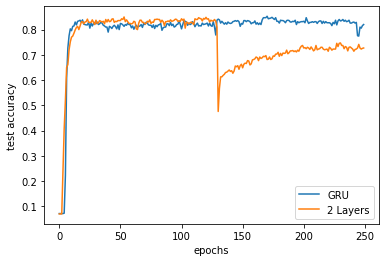

In [ ]:
# Plot test accuracy of between
pylab.figure()
pylab.plot(np.arange(no_epochs), test_acc_charRNN_dropout, label='GRU')
pylab.plot(np.arange(no_epochs), test_acc_charRNN_increase, label='2 Layers')
pylab.xlabel('epochs')
pylab.ylabel('test accuracy')
pylab.legend(loc='lower right')

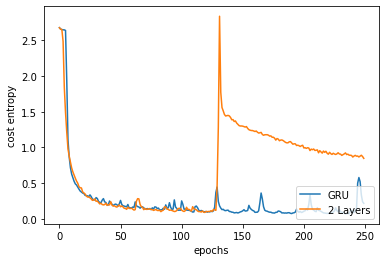

In [ ]:
# Plot cost entropy of between
pylab.figure()
pylab.plot(np.arange(no_epochs), train_loss_charRNN_dropout, label='GRU')
pylab.plot(np.arange(no_epochs), train_loss_charRNN_increase, label='2 Layers')
pylab.xlabel('epochs')
pylab.ylabel('cost entropy')
pylab.legend(loc='lower right')

In [ ]:
class WordRNN_increase(Model):

    def __init__(self, vocab_size, hidden_dim=10, add_dropout = False):
        super(WordRNN_increase, self).__init__()
        # Hyperparameters
        self.hidden_dim = hidden_dim
        self.vocab_size = vocab_size
        self.add_dropout = add_dropout
        self.embedding = layers.Embedding(vocab_size, EMBEDDING_SIZE, input_length=MAX_DOCUMENT_LENGTH)
        # Weight variables and RNN cell
        self.rnn = layers.RNN(
            tf.keras.layers.StackedRNNCells([tf.keras.layers.GRUCell(self.hidden_dim), 
                                             tf.keras.layers.GRUCell(self.hidden_dim)]), unroll=True)
        self.dense = layers.Dense(MAX_LABEL, activation=None)

    def call(self, x, drop_rate):
        # forward logic
        embedding = self.embedding(x)
        encoding = self.rnn(embedding)
        if self.add_dropout:
          encoding = tf.nn.dropout(encoding, drop_rate)
        logits = self.dense(encoding)
    
        return logits

In [ ]:
model_word_increase_rnn = WordRNN_increase(vocab_size, HIDDEN_SIZE, add_dropout = True)

# Choose optimizer and loss function for training
optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
# Select metrics to measure the loss and the accuracy of the model. 
# These metrics accumulate the values over epochs and then print the overall result.
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')

test_loss = tf.keras.metrics.Mean(name='test_loss')
test_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='test_accuracy')

#Result array
test_acc_wordRNN_increase = []
train_loss_wordRNN_increase = []

#Start program time
start_time = time.time()

for epoch in range(no_epochs):
    # Reset the metrics at the start of the next epoch
    train_loss.reset_states()
    train_accuracy.reset_states()
    test_loss.reset_states()
    test_accuracy.reset_states()

    for images, labels in train_ds:
        train_step(model_word_increase_rnn, images, labels, drop_rate=0.5)

    for images, labels in test_ds:
        test_step(model_word_increase_rnn, images, labels, drop_rate=0)

    test_acc_wordRNN_increase.append(test_accuracy.result())
    train_loss_wordRNN_increase.append(train_loss.result())
    template = 'Epoch {}, Loss: {}, Accuracy: {}, Test Loss: {}, Test Accuracy: {}'
    print (template.format(epoch+1,
                          train_loss.result(),
                          train_accuracy.result(),
                          test_loss.result(),
                          test_accuracy.result()))
    
#Store program execution time
time_wordRNN_increase = time.time() - start_time
print("--- Took: %s seconds ---" % (time_wordRNN_increase))

Epoch 1, Loss: 2.679468870162964, Accuracy: 0.06607142835855484, Test Loss: 2.6494476795196533, Test Accuracy: 0.0714285746216774
Epoch 2, Loss: 2.6572110652923584, Accuracy: 0.07107143104076385, Test Loss: 2.646299123764038, Test Accuracy: 0.07000000029802322
Epoch 3, Loss: 2.6508913040161133, Accuracy: 0.0714285746216774, Test Loss: 2.646235227584839, Test Accuracy: 0.0714285746216774
Epoch 4, Loss: 2.5949079990386963, Accuracy: 0.09285714477300644, Test Loss: 2.2424871921539307, Test Accuracy: 0.17571428418159485
Epoch 5, Loss: 1.9542617797851562, Accuracy: 0.25999999046325684, Test Loss: 1.57272207736969, Test Accuracy: 0.47857141494750977
Epoch 6, Loss: 1.3070720434188843, Accuracy: 0.5121428370475769, Test Loss: 1.070425033569336, Test Accuracy: 0.6614285707473755
Epoch 7, Loss: 0.8254941701889038, Accuracy: 0.7166071534156799, Test Loss: 0.7388579845428467, Test Accuracy: 0.7871428728103638
Epoch 8, Loss: 0.5279263854026794, Accuracy: 0.8319643139839172, Test Loss: 0.67282098531

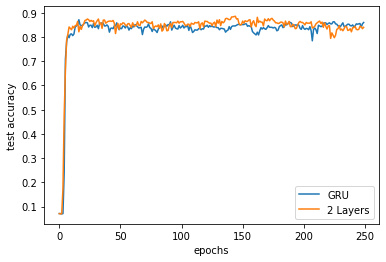

In [ ]:
# Plot test accuracy of between
pylab.figure()
pylab.plot(np.arange(no_epochs), test_acc_wordRNN_dropout, label='GRU')
pylab.plot(np.arange(no_epochs), test_acc_wordRNN_increase, label='2 Layers')
pylab.xlabel('epochs')
pylab.ylabel('test accuracy')
pylab.legend(loc='lower right')

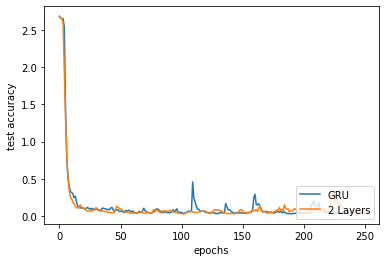

In [ ]:
# Plot cost entropy of between
pylab.figure()
pylab.plot(np.arange(no_epochs), train_loss_wordRNN_dropout, label='GRU')
pylab.plot(np.arange(no_epochs), train_loss_wordRNN_increase, label='2 Layers')
pylab.xlabel('epochs')
pylab.ylabel('cost entropy')
pylab.legend(loc='lower right')

# C) Add gradient clipping to RNN training with clipping threshold = 2

In [ ]:
model_char_rnn_gc = CharRNN(vocab_size, HIDDEN_SIZE, add_dropout = True)

# Choose optimizer and loss function for training
optimizer = tf.keras.optimizers.Adam(learning_rate=lr, clipvalue=2)
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
# Select metrics to measure the loss and the accuracy of the model. 
# These metrics accumulate the values over epochs and then print the overall result.
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')

test_loss = tf.keras.metrics.Mean(name='test_loss')
test_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='test_accuracy')

#Result array
test_acc_charRNN_gc = []
train_loss_charRNN_gc = []

#Start program time
start_time = time.time()

for epoch in range(no_epochs):
    # Reset the metrics at the start of the next epoch
    train_loss.reset_states()
    train_accuracy.reset_states()
    test_loss.reset_states()
    test_accuracy.reset_states()

    for images, labels in train_ds:
        train_step(model_char_rnn_gc, images, labels, drop_rate=0.5)

    for images, labels in test_ds:
        test_step(model_char_rnn_gc, images, labels, drop_rate=0)

    test_acc_charRNN_gc.append(test_accuracy.result())
    train_loss_charRNN_gc.append(train_loss.result())
    template = 'Epoch {}, Loss: {}, Accuracy: {}, Test Loss: {}, Test Accuracy: {}'
    print (template.format(epoch+1,
                          train_loss.result(),
                          train_accuracy.result(),
                          test_loss.result(),
                          test_accuracy.result()))
    
#Store program execution time
time_charRNN_gc = time.time() - start_time
print("--- Took: %s seconds ---" % (time_charRNN_gc))

Epoch 1, Loss: 2.683373212814331, Accuracy: 0.06624999642372131, Test Loss: 2.6534833908081055, Test Accuracy: 0.0714285746216774
Epoch 2, Loss: 2.6599762439727783, Accuracy: 0.07089285552501678, Test Loss: 2.6459672451019287, Test Accuracy: 0.0714285746216774
Epoch 3, Loss: 2.6533970832824707, Accuracy: 0.0714285746216774, Test Loss: 2.6449506282806396, Test Accuracy: 0.07000000029802322
Epoch 4, Loss: 2.6497485637664795, Accuracy: 0.06928571313619614, Test Loss: 2.643284559249878, Test Accuracy: 0.0714285746216774
Epoch 5, Loss: 2.6478402614593506, Accuracy: 0.07232142984867096, Test Loss: 2.642239570617676, Test Accuracy: 0.07285714149475098
Epoch 6, Loss: 2.619292736053467, Accuracy: 0.09214285761117935, Test Loss: 2.430568218231201, Test Accuracy: 0.23714286088943481
Epoch 7, Loss: 2.0692803859710693, Accuracy: 0.22428570687770844, Test Loss: 1.6717554330825806, Test Accuracy: 0.33571428060531616
Epoch 8, Loss: 1.5602000951766968, Accuracy: 0.36571428179740906, Test Loss: 1.285419

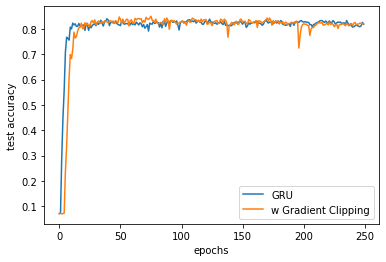

In [ ]:
# Plot test accuracy of between
pylab.figure()
pylab.plot(np.arange(no_epochs), test_acc_charRNN, label='GRU')
pylab.plot(np.arange(no_epochs), test_acc_charRNN_gc, label='w Gradient Clipping')
pylab.xlabel('epochs')
pylab.ylabel('test accuracy')
pylab.legend(loc='lower right')

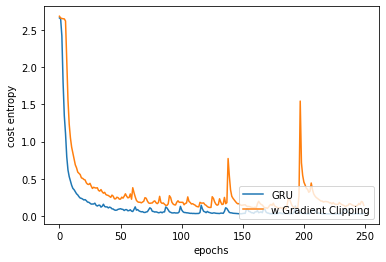

In [ ]:
# Plot cost entropy of between
pylab.figure()
pylab.plot(np.arange(no_epochs), train_loss_charRNN, label='GRU')
pylab.plot(np.arange(no_epochs), train_loss_charRNN_gc, label='w Gradient Clipping')
pylab.xlabel('epochs')
pylab.ylabel('cost entropy')
pylab.legend(loc='lower right')

In [ ]:
model_word_rnn_gc = WordRNN(vocab_size, HIDDEN_SIZE, add_dropout = True)

# Choose optimizer and loss function for training
optimizer = tf.keras.optimizers.Adam(learning_rate=lr, clipvalue=2)
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
# Select metrics to measure the loss and the accuracy of the model. 
# These metrics accumulate the values over epochs and then print the overall result.
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')

test_loss = tf.keras.metrics.Mean(name='test_loss')
test_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='test_accuracy')

#Result array
test_acc_wordRNN_gc = []
train_loss_wordRNN_gc = []

#Start program time
start_time = time.time()

for epoch in range(no_epochs):
    # Reset the metrics at the start of the next epoch
    train_loss.reset_states()
    train_accuracy.reset_states()
    test_loss.reset_states()
    test_accuracy.reset_states()

    for images, labels in train_ds:
        train_step(model_word_rnn_gc, images, labels, drop_rate=0.5)

    for images, labels in test_ds:
        test_step(model_word_rnn_gc, images, labels, drop_rate=0)

    test_acc_wordRNN_gc.append(test_accuracy.result())
    train_loss_wordRNN_gc.append(train_loss.result())
    template = 'Epoch {}, Loss: {}, Accuracy: {}, Test Loss: {}, Test Accuracy: {}'
    print (template.format(epoch+1,
                          train_loss.result(),
                          train_accuracy.result(),
                          test_loss.result(),
                          test_accuracy.result()))
    
#Store program execution time
time_wordRNN_gc = time.time() - start_time
print("--- Took: %s seconds ---" % (time_wordRNN_gc))

Epoch 1, Loss: 2.6783535480499268, Accuracy: 0.06875000149011612, Test Loss: 2.6553735733032227, Test Accuracy: 0.0714285746216774
Epoch 2, Loss: 2.6602656841278076, Accuracy: 0.06732142716646194, Test Loss: 2.643432140350342, Test Accuracy: 0.0714285746216774
Epoch 3, Loss: 2.6523523330688477, Accuracy: 0.06803571432828903, Test Loss: 2.6460068225860596, Test Accuracy: 0.07000000029802322
Epoch 4, Loss: 2.5110673904418945, Accuracy: 0.10571428388357162, Test Loss: 2.086460828781128, Test Accuracy: 0.17428570985794067
Epoch 5, Loss: 1.8037307262420654, Accuracy: 0.3110714256763458, Test Loss: 1.3187528848648071, Test Accuracy: 0.5914285778999329
Epoch 6, Loss: 1.1327742338180542, Accuracy: 0.585357129573822, Test Loss: 0.777155339717865, Test Accuracy: 0.7428571581840515
Epoch 7, Loss: 0.7143222689628601, Accuracy: 0.7530357241630554, Test Loss: 0.6094483733177185, Test Accuracy: 0.8142856955528259
Epoch 8, Loss: 0.5077470541000366, Accuracy: 0.8419643044471741, Test Loss: 0.4973852932

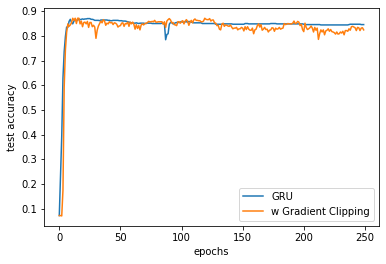

In [ ]:
# Plot test accuracy of between
pylab.figure()
pylab.plot(np.arange(no_epochs), test_acc_wordRNN, label='GRU')
pylab.plot(np.arange(no_epochs), test_acc_wordRNN_gc, label='w Gradient Clipping')
pylab.xlabel('epochs')
pylab.ylabel('test accuracy')
pylab.legend(loc='lower right')

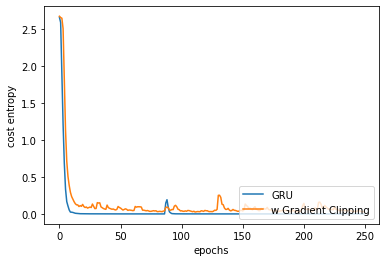

In [ ]:
# Plot cost entropy of between
pylab.figure()
pylab.plot(np.arange(no_epochs), train_loss_wordRNN, label='GRU')
pylab.plot(np.arange(no_epochs), train_loss_wordRNN_gc, label='w Gradient Clipping')
pylab.xlabel('epochs')
pylab.ylabel('cost entropy')
pylab.legend(loc='lower right')